In [1]:
#load library
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.9      ✔ rsample      0.1.0 
✔ dials        0.0.9      ✔ tune         0.1.6 
✔ infer        1.0.0      ✔ workflows    0.2.3 
✔ modeldata    0.1.1      ✔ workflowsets 0.1.0 
✔ parsnip      0.1.7      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks

In [2]:
# Set the seed
set.seed(69)

In [3]:
# Data is read and column names are assigned
data <- read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
colnames(data) <- c('age', 'workclass', 'fnlwgt', 'education', 
                     'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                     'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income')
data

Rows: 32560 Columns: 15

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): State-gov, Bachelors, Never-married, Adm-clerical, Not-in-family, W...
dbl (6): 39, 77516, 13, 2174, 0, 40


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [7]:
# Changing capital_gain and capita_loss into total_capital, and removing irrelevant predictors
data_select <- data %>%
mutate(total_capital = capital_gain - capital_loss) %>%
select(hours_per_week, education_num, age, income)

# Changing data type of some predictors to factor 
data_new <- mutate(data_select, 
                   income = as.factor(income))
data_new

hours_per_week,education_num,age,income
<dbl>,<dbl>,<dbl>,<fct>
13,13,50,<=50K
40,9,38,<=50K
40,7,53,<=50K
⋮,⋮,⋮,⋮
40,9,58,<=50K
20,9,22,<=50K
40,9,52,>50K


In [8]:
# We can use the function below to identify whether there are NA's in our dataset
sum(is.na(data_new))

[1] 0

In [9]:
# Set the seed
set.seed(2020)
# Split the data into a training set and a testing set, with 75% of the data going into the former
data_split <- initial_split(data_new, prop = 0.75, strata = income)
data_train <- training(data_split)
data_test <- testing(data_split)

In [10]:
#preprocess data
set.seed(2020) 

income_recipe <- recipe(income ~ hours_per_week + education_num + age , data = data_train) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())

In [12]:
#building the classifier with k = 3
set.seed(2020)

income_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
      set_engine("kknn") %>%
      set_mode("classification")

income_fit <- workflow() %>%
      add_recipe(income_recipe) %>%
      add_model(income_spec) %>%
      fit(data = data_train)
income_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2048814
Best kernel: rectangular
Best k: 3

In [16]:
set.seed(2020) 

income_test_predictions <- predict(income_fit, data_test) %>%
      bind_cols(data_test)

# your code here

income_test_predictions

.pred_class,hours_per_week,education_num,age,income
<fct>,<dbl>,<dbl>,<dbl>,<fct>
<=50K,40,13,28,<=50K
<=50K,40,14,37,<=50K
<=50K,16,5,49,<=50K
⋮,⋮,⋮,⋮,⋮
<=50K,11,14,32,<=50K
<=50K,40,9,58,<=50K
<=50K,40,9,52,>50K


In [18]:
set.seed(2020) 

income_prediction_accuracy <- income_test_predictions %>%
        metrics(truth = income, estimate = .pred_class)             

# your code here

income_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7679646
kap,binary,0.1985358


In [19]:
set.seed(2020) # DO NOT REMOVE

income_prediction_mat <- income_test_predictions %>% 
      conf_mat(truth = income, estimate = .pred_class)

# your code here

income_prediction_mat

          Truth
Prediction <=50K >50K
     <=50K  5834 1543
     >50K    346  418

In [20]:
#cross-validation
set.seed(2020)

income_vfold <- vfold_cv(data_train, v = 5, strata = income)

In [22]:
set.seed(2020) 

income_resample_fit <- workflow() %>%
      add_recipe(income_recipe) %>%
      add_model(income_spec) %>%
      fit_resamples(resamples = income_vfold)



In [23]:
income_metrics <- collect_metrics(income_resample_fit)
income_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7723904,5,0.001060025,Preprocessor1_Model1
roc_auc,binary,0.6379473,5,0.002536014,Preprocessor1_Model1


In [25]:
set.seed(2020) 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [27]:
set.seed(1234)

knn_results <- workflow() %>%
      add_recipe(income_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = income_vfold, grid = 10) %>%
      collect_metrics()



knn_results
knn_results_accuracy <- knn_results %>%
    filter(.metric == "accuracy")


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7621525,5,0.0007754189,Preprocessor1_Model01
2,roc_auc,binary,0.6139570,5,0.0020605349,Preprocessor1_Model01
3,accuracy,binary,0.7723904,5,0.0010600251,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.7262551,5,0.002506120,Preprocessor1_Model09
14,accuracy,binary,0.7916376,5,0.001173315,Preprocessor1_Model10
14,roc_auc,binary,0.7282320,5,0.002230205,Preprocessor1_Model10


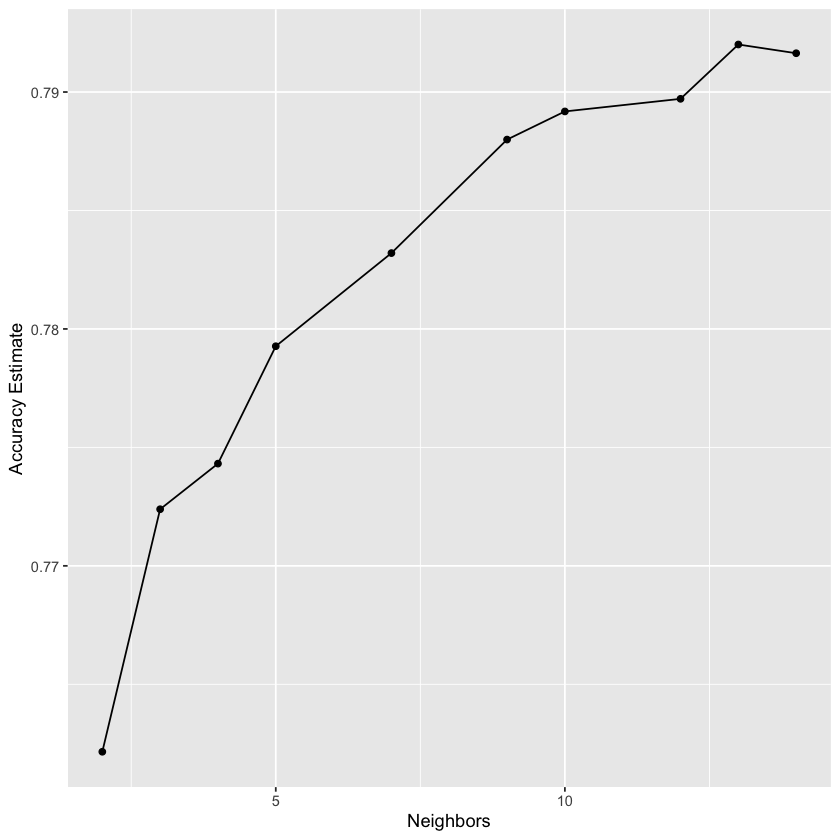

In [28]:
accuracies <- knn_results %>% 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")


accuracy_versus_k

In [31]:
set.seed(2020)
income_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>%
      set_engine("kknn") %>%
      set_mode("classification")

income_best_fit <- workflow() %>%
      add_recipe(income_recipe) %>%
      add_model(income_spec_best) %>%
      fit(data = data_train)
income_best_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1957902
Best kernel: rectangular
Best k: 13

In [33]:
set.seed(2020) 

income_test_best_predictions <- predict(income_best_fit, data_test) %>%
      bind_cols(data_test)
income_test_best_predictions

.pred_class,hours_per_week,education_num,age,income
<fct>,<dbl>,<dbl>,<dbl>,<fct>
<=50K,40,13,28,<=50K
<=50K,40,14,37,<=50K
<=50K,16,5,49,<=50K
⋮,⋮,⋮,⋮,⋮
<=50K,11,14,32,<=50K
<=50K,40,9,58,<=50K
<=50K,40,9,52,>50K


In [34]:
set.seed(2020) 

income_prediction_accuracy_2 <- income_test_best_predictions %>%
        metrics(truth = income, estimate = .pred_class)             

# your code here

income_prediction_accuracy_2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7898293
kap,binary,0.3019905


In [35]:
set.seed(2020) # DO NOT REMOVE

income_prediction_mat_2 <- income_test_best_predictions %>% 
      conf_mat(truth = income, estimate = .pred_class)



income_prediction_mat_2

          Truth
Prediction <=50K >50K
     <=50K  5832 1363
     >50K    348  598